# An Introduction to Dynamic Mode Decomposition (DMD)

This notebook introduces the basics of Dynamic Mode Decomposition (DMD). Some other great tools for learning are:

> [Dynamic Mode Decomposition in Python](http://www.pyrunner.com/weblog/2016/07/25/dmd-python/) from pyrunner

> [Data Driven Science and Engineering](https://www.cambridge.org/core/books/datadriven-science-and-engineering/77D52B171B60A496EAFE4DB662ADC36E) by Steven L. Brunon and J. Nathan Kutz

## Goal:

The goal of DMD is to approximate the leading eigencomposition of (high dimensional) linear operator $A \in \mathbb{C}^{n \times n}$ where $X'=AX$ to find spacial temporal coherant structures of a given (possibly non-linear) system. Simply put:
> "DMD converts a dynamical system into a superposition of modes whose dynamics are governed by eigenvalues." -[pyrunner](http://www.pyrunner.com/weblog/2016/07/25/dmd-python/)

## Inputs to DMD

The following data pair $X$ and $X'$ contain snapshots of data, for example a fluid flow. Here, $n$ is the number of spatial points saved per shot and $m$ is the number of snapshots taken. Recall: $X'=AX$.

- Snapshot (long and skinny) $X = 
 \begin{bmatrix}
  \vert & \vert &     & \vert \\
  x_1   & x_2   & ... & x_{m-1} \\
  \vert & \vert &     & \vert
 \end{bmatrix} \in \mathbb{C}^{n \times (m-1)}$

- Snapshot evolved by one unit in time $X' = 
 \begin{bmatrix}
  \vert & \vert &     & \vert \\
  x_2   & x_3   & ... & x_{m} \\
  \vert & \vert &     & \vert
 \end{bmatrix} \in \mathbb{C}^{n \times (m-1)}$

# DMD at a Glance:

**1. Compute Singular Value Decomposition (SVD) of big data matrix $X$ to find the dominant coherent structures (Columns of $U$).**

The results of the SVD can be truncated when , for example, 99% of the system energy is captured by the first $r$ comumns of $U$. The * is for complex conjugate transpose.

$$ X = U\Sigma V^* $$

**2. Project $A$ on the columns of $U$ to get the reduced dynamic operator $\tilde{A}$**

Inserting $X$ from the SVD into $X' = AX$ results in $ X' = AU\Sigma V^* $. Instead of doing a (very demanding) pseudo-inverse to find the full matrix $A$, $A$ is projected onto the dominant singluar vectors of $U$ (others were truncated). Reduced matrix $\tilde{A}$, which is only of the magnitude of time, is a linear best fit dynamical system, that tell you how your POD modes evolve over time.

$$U^*X'V\Sigma^{-1} = U^*AU = \tilde{A}$$

**3. Compute the eigenvalues $\Lambda$ and eigenvectors $W$ of $\tilde{A}$**

$\tilde{A}$ has the same non-zero *eigenvalues* as $A$. We can therefore compute the eigenvalues $\Lambda$ of $A$ with:

$$\tilde{A}W = W\Lambda$$

**4. Compute the eigenvectors $\Phi$ of $A$**

The eigenvectors $\Phi$ are called *DMD modes*.

$$\Phi = X'V\Sigma^{-1}W$$


Check out [dmdbook.com](http://dmdbook.com/) or [YouTube](https://www.youtube.com/watch?v=sQvrK8AGCAo&t=611s&ab_channel=SteveBrunton) for a better explanation.

With our (spacial) modes $\Phi$ and (temporal) eigenvalues $\Lambda$, we can analyse a system or predict (to a certain extent) what that system will do in the future.

$$\hat{X}(k\Delta t) = \Phi\Lambda^kb_0$$

$\hat{X}$ is a future state prediction of $X$.

$\Lambda^k$ advances one time increment $\Delta t$ with each $k$.

$b_0$ is amplitude of modes. Condition for how much each mode is expressed in the data.

# Simple DMD Example

For this introduction, we will use PyTorch for the linear algebra tasks and Matplotlib for plotting.

In [1]:
from matplotlib import rcParams, rc, cm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.animation as ani

import torch as pt
import numpy as np

pt.__version__

'1.7.1'

### Meshgrid
A small meshgrid is created for the discretization of the data.

*Note: The inputs of Pytorch.meshgrid(t,x) are flipped compared to numpy.meshgrid(x,t). See [documentation](https://pytorch.org/docs/master/generated/torch.meshgrid.html).*

*Note: PyTorch has no built in Pi-Function. See [forum post](https://discuss.pytorch.org/t/np-pi-equivalent-in-pytorch/67157).*

In [2]:
pt.pi = pt.acos(pt.zeros(1)).item()*2 # PyTorch has no built in Pi function

def create_mesh(x_start, x_end, n_x, t_start, t_end, n_t):
    x = pt.linspace(x_start, x_end, n_x)
    t = pt.linspace(t_start, t_end, n_t)
    return pt.meshgrid(t, x)

Tm, Xm = create_mesh(-10, 10, 100, 0, 6*pt.pi, 80)

 ### Inputs
Artificial data is created from the following functions f1, f2, and f3:

The temporal changes are visualized by a decreasing of the opacity. Therefore, $𝑡_0$ is darkest, with the opacity decreasing with every time increment.

In [124]:
def plot_data(x, modes, n):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    for i in range(12):
        ax.scatter(x, pt.real(modes[:, i]), s=8, c='C{}'.format(n-1), alpha=1-(i/11))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel('$f{}$'.format(n))
    if n>3:
        ax.set_ylabel('f1+f2+f3')
    ax.set_xlim(pt.min(x), pt.max(x))

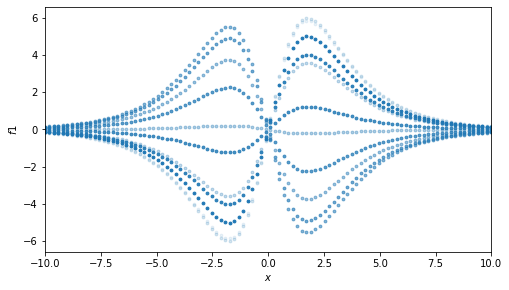

In [120]:
f1 = pt.multiply(10*pt.tanh(Xm/2)/pt.cosh(Xm/2), pt.exp((0.1+2.8j)*Tm)).T

plot_data(Xm[0,:], f1, 1)

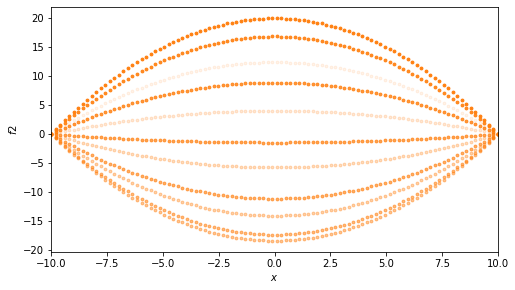

In [121]:
f2 = pt.mul(20-0.2*pt.pow(Xm, 2), pt.exp((-0.05+2.3j)*Tm)).T

plot_data(Xm[0,:], f2, 2)

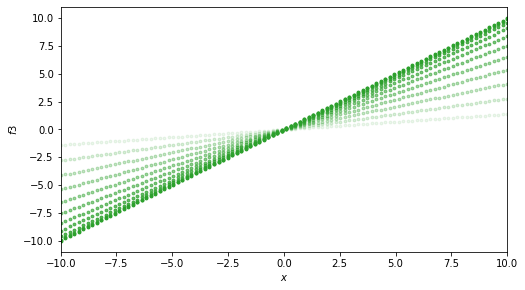

In [122]:
f3 = pt.multiply(Xm, pt.exp(0.6j*Tm)).T

plot_data(Xm[0,:], f3, 3)

### Combining Data:
The signals are combined into one data matrix. The individual modes remain recognizable. The $X$ and $X'$ Snapshots are created at this point. We now have our input data.

Again: $t_0$ is darkest, with the opacity decreasing with time.

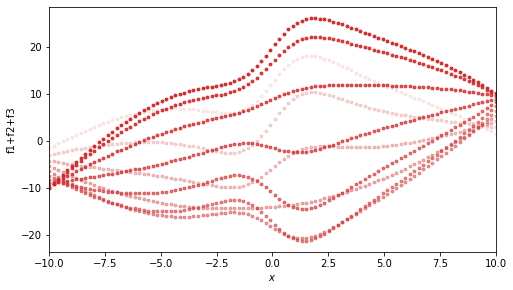

In [125]:
data = f1 + f2 + f3

plot_data(Xm[0,:], data, 4)

#Create our two data snapshots X and X'
X = data[:,:-1]
X_prime = data[:,1:]

### Singular Value Decomposition (SVD)

The following function is defined to compute the SVD of $X$, the first step of DMD.

pt.svd() returns the reduced SVD by default, which might be necessary, depending on the size of the data. **is there an economy svd in pt? is this the same?**

*Note: torch.svd() is depricated. In torch 1.8, [torch.linalg.svd](https://pytorch.org/docs/1.8.0/linalg.html#torch.linalg.svd) will function like numpy.linalg.svd(), but this is not available in Version 1.7.1*

In [9]:
'''
Returns the singular value decomposition of data matrix.

        Parameters:
                matrix (PyTorch.tensor(something))
        Returns:
                U (unitary matrix): columns are called left singular vectors
                s (tensor): real, nonnegative diagonal elements of Sigma
                V (matrix): columns are called right singular vectors
'''
U_temp, s_temp, V_temp = pt.svd(X, some=False)    #!! returns V, not V* !!

### Truncating

Columns of U are the dominant coherant structures, or POD modes. For more on POD, check out the *POD notebook*.

The diagonal elements of $\Sigma$ are singualar values, ordered from largest to smallest (for fluids from high-energy to low). We can easily graph these (small order: $s \in \mathbb{C}^{m}$) to determine which ones are relevant to our data.

For this example, we can easily see that all of our data is represented by only 3 modes. We therefore keep 3 modes and to truncate the rest. By reducing the dimensionality of our system, we potentially save a lot of processing power during the following DMD steps.

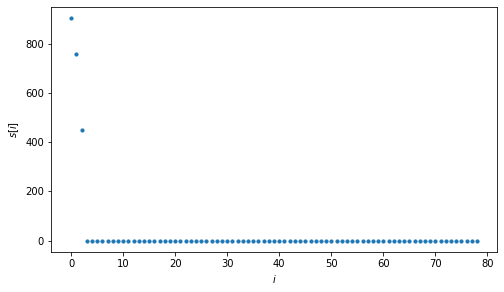

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
ax.set_ylabel('$s[i]$')
ax.set_xlabel('$i$')

plt.scatter(range(s_temp.shape[0]), s_temp, s=10, c='C0')
plt.show()

rank = 3 #truncate after first three modes

U = U_temp[:,:rank]
s = s_temp[:rank]
V = V_temp[:,:rank].conj()      #<--- complex conjugate needed, transpose not.

### Building Reduced Matrix $\tilde{A}$

After finding the SVD of our matrix, we can build $\tilde{A} = U^*X'V\Sigma^{-1}$.

$\Sigma$ is a diagonal matrix and can therefore be inversed using 1/diag_elements.

The eigenvalues and eigenvectors of $\tilde{A}$ are computed using pt.eig(). Since Pytorch does not currently support complex tensor operations (see [forum](https://discuss.pytorch.org/t/how-to-use-complex-eigenvalues/71983)), we will use np.linalg.eig() for this example.

Here $X=matrix[:,:-1]$ and $X'=matrix[:,1:]$, which is $X$ advanced one time step.

Finally, the eigenvectors of A $\Phi$ are computed and returned together with the eigenvalues (same for A and At). 

In [43]:
'''
Returns the eigenvalues and eigenvectors of the data matrix.

        Parameters:
                matrix (PyTorch.tensor(something)): contains snapshots of data X and X'
        Returns:
                val (tensor): eigenvalues of data matrix
                phi (tensor): eigenvectors (modes) of data matrix
'''
s_inv = pt.diag(1.0/s).type(pt.complex64) #type cast since Sigma is only real
    
A_tilde = U.conj().T @ X_prime @ V @ s_inv
    
val, vec = np.linalg.eig(A_tilde)

val = pt.from_numpy(val) #so we can continue working with PyTorch
vec = pt.from_numpy(vec)

## Eigenvalues $\Lambda$

Graphing the resulting eigenvalues leads to some insightful information on the behavior of the respective DMD mode. 

| Eigenvalue          | DMD Mode     |
|:--------------------|:-------------|
| $Im \neq 0$         | oscillation  |
|inside unit circle   | decaying     |
|on unit circle       | not changing |
|ouside unit circle   | growing      |

The behavior of the modes for our example are can therefore be determined as follows: $\lambda_1$ is growing and oscillating the most, mode $\lambda_2$ is decaying and oscillating, and $\lambda_3$ is neither growing nor decaying and oscillating the least. This behavior is expected, since we created the data and know how the modes should act.

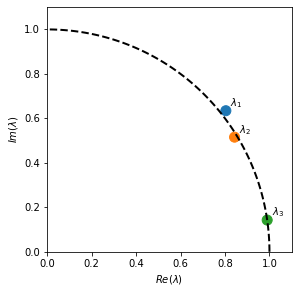

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
t = pt.linspace(0.0, pt.pi/2, 100)
ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
colors = ["C{:d}".format(i) for i in range(len(val))]
ax.scatter(pt.real(val), pt.imag(val), color=colors, marker="o", s=100)
for i in range(len(val)):
    ax.annotate(r"$\lambda_{:d}$".format(i+1), (pt.real(val[i])+0.02, pt.imag(val[i])+0.02))
ax.set_xlabel(r"$Re(\lambda)$")
ax.set_ylabel(r"$Im(\lambda)$")
ax.set_xlim(0.0, 1.1)
ax.set_ylim(0.0, 1.1)
ax.set_aspect(1)

## Eigenvector (modes) $\phi$

Finding the exact DMD modes $\phi$ is the last step of DMD. These spacial temporal coherant structures give us an insight on how the system evolves. The similarity of these modes $\phi_1$, $\phi_2$, $\phi_3$ with our original data functions $f_1$, $f_2$, $f_3$ should be apparant. The colors have been matched to further illustrate the similarity.

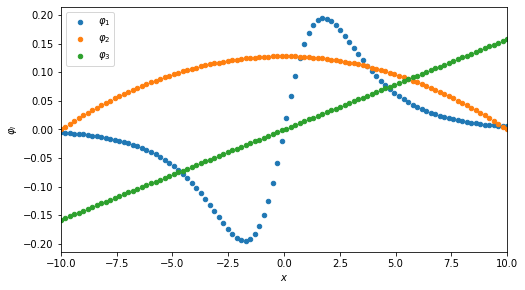

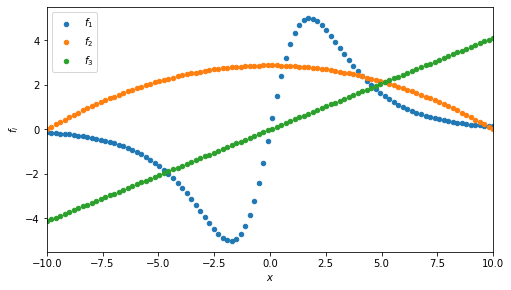

In [128]:
phi = X_prime @ V @ s_inv @ vec #exact DMD modes



def plot_dmd_modes(x, modes):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    for i in range(modes.shape[1]):
        ax.scatter(x, pt.real(modes[:, i]), s=20, label=r"${:s}_{:d}$".format(r"{\varphi}", i+1))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$\varphi_i$")
    ax.set_xlim(pt.min(x), pt.max(x))
    ax.legend()
    
    
def plot_og_data(x, f1, f2, f3):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    one = ax.scatter(x, pt.real(f1[:, 0]), s=20, c='C0')
    two = ax.scatter(x, pt.real(f2[:, 14]), s=20, c='C1')     #ein bisschen hingeschumelt..?
    three = ax.scatter(x, pt.real(f3[:, 8]), s=20, c='C2')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel('$f_i$')
    ax.set_xlim(pt.min(x), pt.max(x))
    ax.legend((one, two, three),('$f_1$','$f_2$','$f_3$'))

plot_dmd_modes(Xm[0,:], phi)

plot_og_data(Xm[0,:], f1, f2, f3)

# Now what?

With our (spacial) modes $\phi$ and (temporal) eigenvalues $\Lambda$, we can analyse a system or predict (to a certain extent) what that system will do in the future. For S

## References

1. Kutz, J. N., Brunton, S. L. 1., Brunton, B. W., & Proctor, J. L. (2016). *Dynamic Mode Decomposition.* Philadelphia, PA, USA: Society for Industrial and Applied Mathematics.
2. Taylor, R. (2016) Dynamic Mode Decomposition in Python. *Pyrunner.* Accessed: 25 January 2021. http://www.pyrunner.com/weblog/2016/07/25/dmd-python/    

## Questions:

- Color matching
- conj() for V, but not .T
- parentheses for im part in data... smh
- comparing phi with f..?

- look at docstring notation in flowtorch/data/foamdataloader source code

![SegmentLocal](f1_f2_f3.gif "segment")